In [1]:
%run ../yp_utils.py

# Initial setup

In [2]:
paper_pmid = 23825022
paper_name = 'choy_basrai_2013' 

In [3]:
datasets = pd.read_csv('extras/YeastPhenome_' + str(paper_pmid) + '_datasets_list.txt', sep='\t', header=None, names=['dataset_id', 'name'])

In [4]:
datasets.set_index('dataset_id', inplace=True)

# Load & process the data

In [5]:
sheets = ['X YMB1004','X YMB1005']

In [23]:
original_data_list = []
for s in sheets:
    original_data = pd.read_excel('raw_data/Final HIS Data.xlsx', sheet_name=s)
    print('Original data dimensions: %d x %d' % (original_data.shape))
    original_data['orf'] = original_data['ORF'].astype(str)
    
    original_data = original_data.loc[original_data['orf'] != 'nan',:]
    
    # Remove the underscore annotations
    original_data['orf'] = original_data['orf'].apply(lambda x: x.split('_')[0])
    
    original_data['orf'] = clean_orf(original_data['orf'])
    
    typo_fixes = {'YCLO51W':'YCL051W','YGR122C-':'YGR122C-A','YHR139C-':'YHR139C-A'}
    original_data['orf'] = original_data['orf'].apply(lambda x: typo_fixes[x] if x in typo_fixes.keys() else x)
    
    original_data['orf'] = translate_sc(original_data['orf'], to='orf')
    t = looks_like_orf(original_data['orf'])
    print(original_data.loc[~t,])
    original_data = original_data.loc[t,:]
    original_data.set_index('orf', inplace=True)
    
    original_data['data'] = original_data[['Screen 1 Score','Screen 2 Score','Screen 3 Score']].mean(axis=1)
    original_data = original_data[['data']].copy()
    
    original_data = original_data.groupby(original_data.index).mean()
    print(original_data.shape)
    
    original_data_list.append(original_data)

Original data dimensions: 7296 x 10
             Plate  Number        ORF  Screen 1 Score  Screen 2 Score  \
index_input                                                             
6577            18      50  YER186W-A               1               0   
6598            18      71    YER109C               1               1   

             Screen 3 Score  Sum of Scores  Product of Scores  Gene  \
index_input                                                           
6577                      0              1                  0   NaN   
6598                      0              2                  0  FLO8   

                                                    Annotation  orf  
index_input                                                          
6577                                                       NaN  NaN  
6598         Transcription factor required for flocculation...  NaN  
(6093, 1)
Original data dimensions: 7296 x 10
             Plate  Number        ORF  Screen 1 Score  Scree

In [32]:
original_data = pd.concat(original_data_list, axis=0)

In [33]:
original_data = original_data.groupby(original_data.index).mean()
print(original_data.shape)

(6093, 1)


### Test

In [34]:
data_s1 = pd.read_excel('raw_data/table_s1.xlsx', sheet_name='Table 1', skiprows=2)

In [35]:
data_s1.set_index('ORF', inplace=True)

In [36]:
data_s1['tmp'] = original_data.reindex(index=data_s1.index)['data']

In [37]:
import matplotlib.pyplot as plt

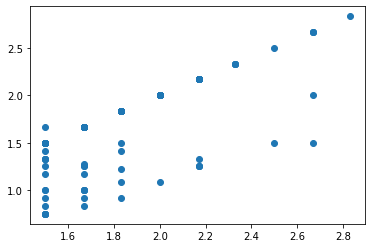

In [38]:
plt.scatter(data_s1['aAverage\nScore'], data_s1['tmp'])

# Prepare the final dataset

In [39]:
data = original_data.copy()

In [40]:
dataset_ids = [16003]
datasets = datasets.reindex(index=dataset_ids)

In [41]:
lst = [datasets.index.values, ['value']*datasets.shape[0]]
tuples = list(zip(*lst))
idx = pd.MultiIndex.from_tuples(tuples, names=['dataset_id','data_type'])
data.columns = idx

In [42]:
data.head()

dataset_id,16003
data_type,value
orf,
YAL001C,1.166667
YAL002W,0.666667
YAL003W,0.666667
YAL004W,1.000000
YAL005C,2.000000


## Subset to the genes currently in SGD

In [43]:
genes = pd.read_csv(path_to_genes, sep='\t', index_col='id')
genes = genes.reset_index().set_index('systematic_name')
gene_ids = genes.reindex(index=data.index.values)['id'].values
num_missing = np.sum(np.isnan(gene_ids))
print('ORFs missing from SGD: %d' % num_missing)

ORFs missing from SGD: 32


In [44]:
data['gene_id'] = gene_ids
data = data.loc[data['gene_id'].notnull()]
data['gene_id'] = data['gene_id'].astype(int)
data = data.reset_index().set_index(['gene_id','orf'])

data.head()

,dataset_id,16003
,data_type,value
gene_id,orf,
1,YAL001C,1.166667
2,YAL002W,0.666667
3,YAL003W,0.666667
1863,YAL004W,1.000000
4,YAL005C,2.000000


# Normalize

In [45]:
data_norm = normalize_phenotypic_scores(data, has_tested=True)

In [46]:
# Assign proper column names
lst = [datasets.index.values, ['valuez']*datasets.shape[0]]
tuples = list(zip(*lst))
idx = pd.MultiIndex.from_tuples(tuples, names=['dataset_id','data_type'])
data_norm.columns = idx

In [47]:
data_norm[data.isnull()] = np.nan
data_all = data.join(data_norm)

data_all.head()

dataset_id          16003          
data_type           value    valuez
gene_id orf                        
1       YAL001C  1.166667  1.385050
2       YAL002W  0.666667  0.213085
3       YAL003W  0.666667  0.213085
1863    YAL004W  1.000000  0.994395
4       YAL005C  2.000000  3.338325

# Print out

In [48]:
for f in ['value','valuez']:
    df = data_all.xs(f, level='data_type', axis=1).copy()
    df.columns = datasets['name'].values
    df = df.droplevel('gene_id', axis=0)
    df.to_csv(paper_name + '_' + f + '.txt', sep='\t')

# Save to DB

In [49]:
from IO.save_data_to_db3 import *

In [50]:
save_data_to_db(data_all, paper_pmid)

  0%|          | 0/1 [00:00<?, ?it/s]

Deleting all datasets for PMID 23825022...
Inserting the new data...


100%|██████████| 1/1 [00:09<00:00,  9.27s/it]

Updating the data_modified_on field...
